In [47]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary
import torchvision as tv
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [48]:
# Download the data from torchvision
cdata = tv.datasets.EMNIST(root="emnist", split="letters", download=True)

In [49]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + " classes")

print("\nData size:")
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.view([124800, 1, 28, 28]).float()
print("\nTensor data:")
print(images.shape)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [50]:
# brief aside: class 'N/A' doesn't exist in the data.
print(torch.sum(cdata.targets == 0))

# However, it causes problems in one-hot encoding...
torch.unique(cdata.targets)

cdata.class_to_idx

tensor(0)


{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [51]:
# Remove N/A from the classes
letterCategories = cdata.classes[1:]

# Re-label the labels to start from 0 instead of 1 ( As N/A category starts with 0)
labels = copy.deepcopy(cdata.targets) - 1

In [52]:
# Normalize the images
images = images / torch.max(images)

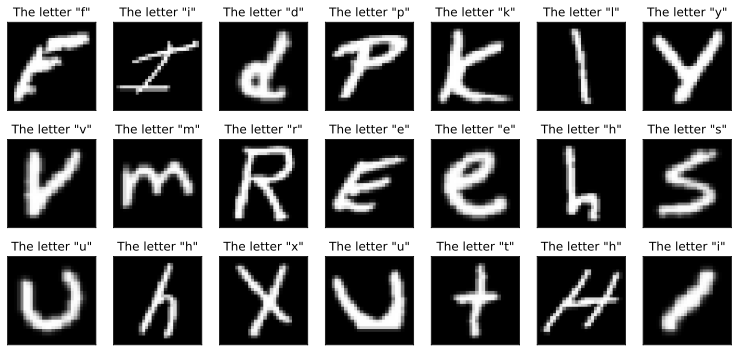

In [53]:
# Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):
    # Pick a random pic
    whichPic = np.random.randint(images.shape[0])

    # Extract the image and its target letter
    I = np.squeeze(images[whichPic, :, :])
    letter = letterCategories[labels[whichPic]]

    # Visualize
    ax.imshow(I.T, cmap="gray")
    ax.set_title('The letter "%s"' % letter)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [54]:
images = images.to(device)
labels = labels.to(device)
# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.1
)

# Step 3: convert into PyTorch Datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Translate into dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device=device),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset.tensors[0].shape[0],
    generator=torch.Generator(device=device),
)

In [55]:
# Util Functions
# Get input size
def get_fc_input_size(image_size_x, image_size_y, channels):
    return int(image_size_x * image_size_y * channels)


# Image size calculator
def get_output_image_size(image_size, stride, kernel_size, padding):
    return int(
        np.floor(np.floor((image_size + 2 * padding - kernel_size) / stride + 1) / 2)
    )

In [56]:
# Create the DL model function
def createTheEMNISTNet(conv1_ch, conv2_ch, image_size, print_toggle=False):
    class emnistNet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()
            # print toggle
            self.print = print_toggle
            self.conv1_ch = conv1_ch
            self.conv2_ch = conv2_ch
            self.image_size = image_size
            ### -------------- feature map layers -------------- ###
            # first convolution layer
            self.conv1 = nn.Conv2d(1, self.conv1_ch, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(
                self.conv1_ch
            )  # input the number of channels in this layer
            # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)
            output_size_conv1 = get_output_image_size(image_size=image_size, stride=1, kernel_size=3, padding=1)

            # second convolution layer
            self.conv2 = nn.Conv2d(self.conv1_ch, self.conv2_ch, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(
                self.conv2_ch
            )  # input the number of channels in this layer
            # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)
            output_size_conv2 = get_output_image_size(
                image_size=output_size_conv1, stride=1, kernel_size=3, padding=1
            )
            ### -------------- linear decision layers -------------- ###
            input_size_fc1 = get_fc_input_size(
                output_size_conv2, output_size_conv2, self.conv2_ch
            )
            self.fc1 = nn.Linear(input_size_fc1, 64)
            self.fc2 = nn.Linear(64, 26)

        def forward(self, x):

            if self.print:
                print(f"Input: {list(x.shape)}")

            # first block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv1(x)
            x = F.max_pool2d(x, 2)
            x = self.bnorm1(x)
            x = F.leaky_relu(x)
            if self.print:
                print(f"First CPR block: {list(x.shape)}")

            # second block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv2(x)
            x = F.max_pool2d(x, 2)
            x = self.bnorm2(x)
            x = F.leaky_relu(x)
            if self.print:
                print(f"Second CPR block: {list(x.shape)}")

            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print:
                print(f"Vectorized: {list(x.shape)}")

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            if self.print:
                print(f"Final output: {list(x.shape)}")

            return x

    # Model instance
    net = emnistNet(print_toggle)

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer

In [57]:
net, lossFun, optimizer = createTheEMNISTNet(
    6, 6, 28, True
)
X, y = next(iter(train_loader))
yHat = net(X)

# Check the output size
print(f"Output size: {yHat.shape}\n")

# Loss Function
loss = lossFun(yHat, torch.squeeze(y))
print(f"Loss: {loss}")

Input: [32, 1, 28, 28]
First CPR block: [32, 6, 14, 14]
Second CPR block: [32, 6, 7, 7]
Vectorized: [32, 294]
Final output: [32, 26]
Output size: torch.Size([32, 26])

Loss: 3.2211544513702393


In [58]:
# Function to train the model
def functionToTrainTheModel(
    conv1_ch,
    conv2_ch,
    image_size,
    epochs=10,
):

    # Create new model
    net, lossFun, optimizer = createTheEMNISTNet(conv1_ch, conv2_ch, image_size, False)

    # initialize losses and errors
    trainLoss = torch.zeros(epochs)
    testLoss = torch.zeros(epochs)
    trainErr = torch.zeros(epochs)
    testErr = torch.zeros(epochs)

    # The Loop
    for epoch in range(epochs):
        net.train()

        # Batch loss and errors
        batchLoss = []
        batchErr = []

        for X, y in train_loader:
            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and error for the batch
            batchLoss.append(loss.cpu().item())
            batchErr.append(
                torch.mean((torch.argmax(yHat, axis=1) != y).float()).cpu().item()
            )
        # End of batch loop

        # Train loss and error
        trainLoss[epoch] = np.mean(batchLoss)
        trainErr[epoch] = 100 * np.mean(batchErr)

        # Test performance
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
            loss = lossFun(yHat, y)
        testLoss[epoch] = loss.cpu().item()
        testErr[epoch] = (
            100 * torch.mean((torch.argmax(yHat, axis=1) != y).float()).cpu().item()
        )
        # End of epoch
    # End of training

    return trainLoss, testLoss, trainErr, testErr, net

In [60]:
# this experiment takes ~8 mins on a GPU
convChans = [2, 5, 8]

# initialize results matrix
results = np.zeros((len(convChans), len(convChans), 2))
convParams = np.zeros((len(convChans), len(convChans)))

for i, Nchani in enumerate(convChans):
    for j, Nchanj in enumerate(convChans):

        # run the model
        trainLoss, testLoss, trainErr, testErr, net = functionToTrainTheModel(
            Nchani, Nchanj, 28, epochs=5
        )
        # get results
        results[i, j, :] = trainErr[-1].cpu().detach(), testErr[-1].cpu().detach()
        convParams[i, j] = Nchani + Nchanj  # total number of convolution layer channels

        print(i, j)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


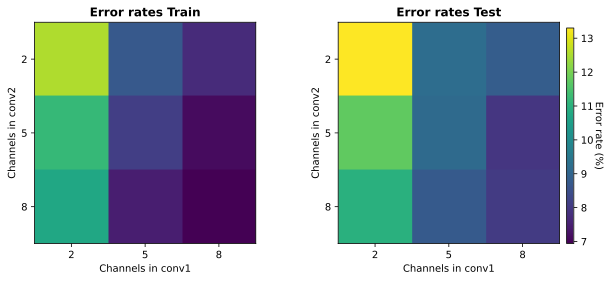

In [63]:
# Show the results matrix

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):
    h = ax[i].imshow(results[:, :, i], vmin=np.min(results), vmax=np.max(results))
    ax[i].set_xlabel("Channels in conv1")
    ax[i].set_ylabel("Channels in conv2")
    ax[i].set_xticks(range(j + 1))  # j defined in previous cell
    ax[i].set_yticks(range(j + 1))
    ax[i].set_xticklabels(convChans)
    ax[i].set_yticklabels(convChans)
    title = "Train" if i == 0 else "Test"
    ax[i].set_title("Error rates %s" % title, fontweight="bold")


# add a colorbar right of the plot (use common colorscaling for both plots)
axpos = ax[1].get_position()
cax = fig.add_axes([axpos.x1 + 0.01, axpos.y0, 0.01, 0.75])
hh = fig.colorbar(h, cax=cax)
hh.set_label("Error rate (%)", rotation=270, labelpad=10)

plt.show()

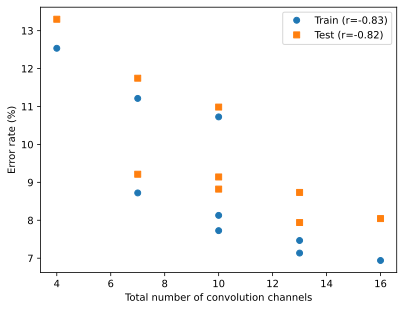

In [64]:
# error rate as a function of the total number of conv channels

corrTrain = np.corrcoef(convParams.flatten(), results[:, :, 0].flatten())
corrTest = np.corrcoef(convParams.flatten(), results[:, :, 1].flatten())

# plots
plt.plot(
    convParams.flatten(),
    results[:, :, 0].flatten(),
    "o",
    label=f"Train (r={corrTrain[0,1]:.2f})",
)
plt.plot(
    convParams.flatten(),
    results[:, :, 1].flatten(),
    "s",
    label=f"Test (r={corrTest[0,1]:.2f})",
)

# other stuff etc
plt.legend()
plt.xlabel("Total number of convolution channels")
plt.ylabel("Error rate (%)")
plt.show()